Matt's parcels tests

In [1]:
# imports modules and renames them short names
import numpy as np
import xarray as xr
import os
from matplotlib import pyplot as plt, animation
from datetime import datetime, timedelta
from dateutil.parser import parse
from IPython.display import HTML
from salishsea_tools import nc_tools, places

# imports functions from the parcels module
from parcels import FieldSet, Field, VectorField, ParticleSet, JITParticle, ErrorCode, AdvectionRK4, AdvectionRK4_3D, plotTrajectoriesFile

# makes the plots show up below the code cells
%matplotlib inline

In [2]:
# Sets the default font size of matplotlib plots
plt.rcParams['font.size'] = 12

Fieldset functions

In [11]:
def fieldset_from_nemo(daterange, coords):
    """Generate a fieldset from a hourly SalishSeaCast forcing fields
    over daterange.
    """

    # Generate sequential list of forcing file prefixes
    prefixes = [
        nc_tools.get_hindcast_prefix(daterange[0] + timedelta(days=d)) # This uses the get_hindcast_prefix function which I think is from SalishSeaTools and was made by the MOAD group. It sets the prefix with results/salishsea... etc. so you dont have to specify that
        for d in range(np.diff(daterange)[0].days + 1)
    ]

    # Predefine fieldset argument dictionaries
    filenames, variables, dimensions = {}, {}, {}

    # Define dict fields for each variable. This might be where I would add other variables from the model
    for var, name in zip(['U', 'V', 'W'], ['vozocrtx', 'vomecrty', 'vovecrtz']):

        # Dict of filenames containing the coordinate and forcing variables
        datafiles = [prefix + f'_grid_{var}.nc' for prefix in prefixes]
        filenames[var] = {'lon': coords, 'lat': coords, 'data': datafiles}

        # NEMO variable name
        variables[var] = name

        # Dict of NEMO coordinate names (f-points)
        dimensions[var] = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time_counter'}
        
        # Add depth fields (f-points are on W grid)
        filenames[var]['depth'] = prefixes[0] + '_grid_W.nc'
        dimensions[var]['depth'] = 'depthw'

    # Load NEMO forcing into fieldset
    field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)
    
    return field_set

Kernels

In [12]:
# I think this causes any particle that goes outside the boundary to be deleted
def DeleteParticle(particle, fieldset, time):
    print(f'Particle {particle.id} lost !! [{particle.lon}, {particle.lat}, {particle.depth}, {particle.time}]')
    particle.delete()

Simulations

In [13]:
# Paths and filenames
paths = {
    'coords': '/data/SalishSeaCast/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/SalishSeaCast/grid/mesh_mask201702.nc',
    'results': '/ocean/mattmiller/MOAD/analysis-matt/results/parcels/test',
}

# Load coords and mask files and extract grid variables
coords, mask = [xr.open_dataset(paths[key], decode_times=False) for key in ('coords', 'mask')]
gridlon, gridlat = [coords[key][0, ...].values for key in ('glamt', 'gphit')]
tmask = mask.tmask[0, 0, ...].values

# Define release parameters
location = 'Strait of Georgia' # there are predefined location names built into SalishSeaTools, under salishsea_tools.places.PLACES which can be found easily on github
n = 100   # number of particles
r = 50   # radius of particle cloud [m]

# Start time, duration and timestep
start = datetime(2019, 1, 1, 12, 30, 0) # year, month, day, hour, minute, second
duration = timedelta(days=3) # the total duration of the simulation
dt = timedelta(seconds=90) # the timestep - toggle between + and - to run forwards or reverse
# is this the timestep that parcels uses or of the fieldset from SalishSeaCast?

# Create Gaussian distribution around release point
mean, cov = [0, 0], [[r**2, 0], [0, r**2]]
x_offset, y_offset = np.random.multivariate_normal(mean, cov, n).T
lon, lat = places.PLACES[location]['lon lat']
lons = lon + x_offset / 111000 / np.cos(np.deg2rad(lat)) # this code might be used to convert from SalishSeaCast's grid to a lat lon grid, since it is an angled domain grid
lats = lat + y_offset / 111000

# Forcing daterange (I add 1-day buffers)
daterange = [start - timedelta(days=1), start + duration + timedelta(days=1)]

# Output file prefix
strings = [location] + [t.strftime('%Y%m%dT%H%M%S') for t in (start, start + duration)]
prefix = os.path.join(paths['results'], '_'.join(strings))

Particle simulations (3D)

Build forcing fieldset

In [14]:
# Load SalishSeaCast results into fieldset
fieldset = fieldset_from_nemo(daterange, paths['coords'])

         It will be opened with no decoding. Filling values might be wrongly parsed.


Run simulation with NEMO forcing - only need to do once with current particle settings, then can load the particle file in the plot codes below

In [30]:
# Execute NEMO-only, 3D run, release at 5m
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lons, lat=lats, depth=np.repeat(5, n), time=np.repeat(start, n))
kernel = AdvectionRK4_3D
output_file = pset.ParticleFile(name=prefix + '_NEMO_3D.zarr', outputdt=timedelta(hours=1))
pset.execute(
    kernel, runtime=duration, dt=dt, output_file=output_file,
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-2928/libcd4da4ae6c141826c9f262277affcb24_0.so
INFO: Output files are stored in /ocean/mattmiller/MOAD/analysis-matt/results/parcels/test/Strait of Georgia_20190101T123000_20190104T123000_NEMO_3D.zarr.
100%|██████████| 259200.0/259200.0 [01:21<00:00, 3169.17it/s]


Visualize results

In [15]:
%%capture

# Make initial figure
fig, ax = plt.subplots(figsize=(8, 8))
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
l = ax.scatter([], [], s=50, c=[], vmin=0, vmax=10, edgecolor='k') # "s" controls the size of the points
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
data = xr.open_dataset(prefix + '_NEMO_3D.zarr') # This line opens the dataset of the particles, so you don't have to run the 
# particle simulation every time you come back to this notebook to play around with it, as long as you want to keep the particles the same
ax.contourf(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='gray')
ax.contour(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.3, -123])
ax.set_ylim([48.7, 49.6])
ax.set_title('NEMO_3D')
ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
    tstamp = data.time[0, hour].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l.set_offsets(np.vstack([data.lon[:, hour], data.lat[:, hour]]).T)
    l.set_array(data.z[:, hour])
    return l, t,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=73, interval=100, blit=True)

In [16]:
# Render animation
HTML(anim.to_html5_video())

This is the end of what I did using Ben's notebook example

From here on is what I have developed

In [55]:
%%capture

# Make initial vertical section profile figure
fig, ax = plt.subplots(figsize=(8, 8)) # names the figure fig and sets the figure size
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # adds colour bar and sets its position
l = ax.scatter([data.lon], [data.z], s=50, c=[data.z], vmin=0, vmax=10, edgecolor='k')
t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
data = xr.open_dataset(prefix + '_NEMO_3D.zarr')
#ax.contourf(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='gray') # don't need these because it's a vertical plot
#ax.contour(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='k')
ax.set_xlim([-124.3, -123])
ax.set_ylim([100, 0])
ax.set_title('NEMO_3D')
ax.set_ylabel('Depth [m]')
#ax.set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l, cax=cax, label='Depth [m]')

# Init function
def init():
    t.set_text('')
    l.set_offsets(np.empty((0, 2)))
    l.set_array(np.empty(0))
    return l, t,

# Animate function
def animate(hour):
    tstamp = data.time[0, hour].values.astype('datetime64[s]').astype(datetime)
    t.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l.set_offsets(np.vstack([data.lon[:, hour], data.z[:, hour]]).T)
    l.set_array(data.z[:, hour])
    return l, t,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=73, interval=100, blit=True)

In [56]:
# Render animation
HTML(anim.to_html5_video())

In [27]:
data = xr.open_dataset(prefix + '_NEMO_3D.zarr')
print(data)

<xarray.Dataset>
Dimensions:     (trajectory: 100, obs: 73)
Coordinates:
  * obs         (obs) int32 0 1 2 3 4 5 6 7 8 9 ... 64 65 66 67 68 69 70 71 72
  * trajectory  (trajectory) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    lat         (trajectory, obs) float64 ...
    lon         (trajectory, obs) float64 ...
    time        (trajectory, obs) datetime64[ns] ...
    z           (trajectory, obs) float64 ...
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_mesh:           spherical
    parcels_version:        2.4.0


/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


In [33]:
print(data.lon[0, 0])

<xarray.DataArray 'lon' ()>
[1 values with dtype=float64]
Coordinates:
    obs         int32 0
    trajectory  int64 0
Attributes:
    axis:           X
    long_name:      
    standard_name:  longitude
    units:          degrees_east


Make side by side map and depth profile

In [127]:
%%capture

# Make initial figure
fig, axs = plt.subplots(1, 2, figsize=(17, 8), gridspec_kw={'wspace': 0.1})
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # do I need this in this side by side?
l0 = axs[0].scatter([data.lon], [data.lat], s=50, c=[data.z], vmin=0, vmax=10, edgecolor='k')
l1 = axs[1].scatter([data.lon], [data.z], s=50, c=[data.z], vmin=0, vmax=10, edgecolor='k')
t0 = axs[0].text(0.02, 0.02, '', transform=axs[0].transAxes)
t1 = axs[1].text(0.02, 0.02, '', transform=axs[1].transAxes)
data = xr.open_dataset(prefix + '_NEMO_3D.zarr') # This line opens the dataset of the particles, so you don't have to run the 
# particle simulation every time you come back to this notebook to play around with it, as long as you want to keep the particles the same
axs[0].contourf(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='gray')
axs[0].contour(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='k')
axs[0].set_xlim([-124.4, -123])
axs[1].set_xlim([-124.4, -123])
axs[0].set_ylim([48.7, 49.8])
axs[1].set_ylim([100, 0])
axs[1].set_ylabel('Depth [m]')
axs[0].set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l1, cax=cax, label='Depth [m]')

# Init function
def init():
    t0.set_text('')
    t1.set_text('')
    l0.set_offsets(np.empty((0, 2)))
    l1.set_offsets(np.empty((0, 2)))
    l0.set_array(np.empty(0))
    l1.set_array(np.empty(0))
    return l0, l1, t0, t1,

# Animate function
def animate(hour):
    tstamp = data.time[0, hour].values.astype('datetime64[s]').astype(datetime)
    t0.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    t1.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l0.set_offsets(np.vstack([data.lon[:, hour], data.lat[:, hour]]).T)
    l1.set_offsets(np.vstack([data.lon[:, hour], data.z[:, hour]]).T)
    l0.set_array(data.z[:, hour])
    l1.set_array(data.z[:, hour])
    return l0, l1, t0, t1,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=73, interval=100, blit=True)

In [128]:
# Render animation
HTML(anim.to_html5_video())

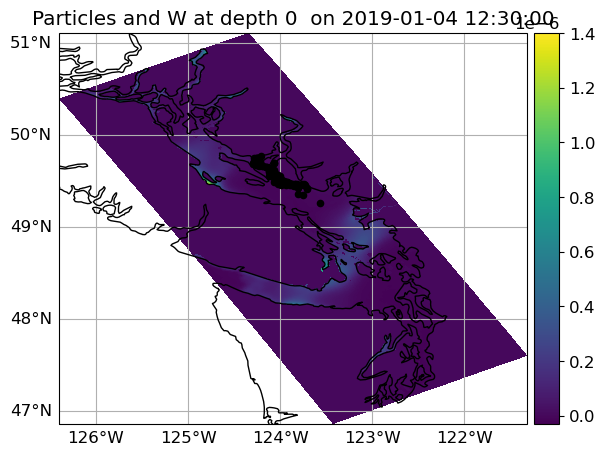

In [76]:
pset.show(field=fieldset.W)


/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/matplotlib/colors.py:1353: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/matplotlib/colors.py:719: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


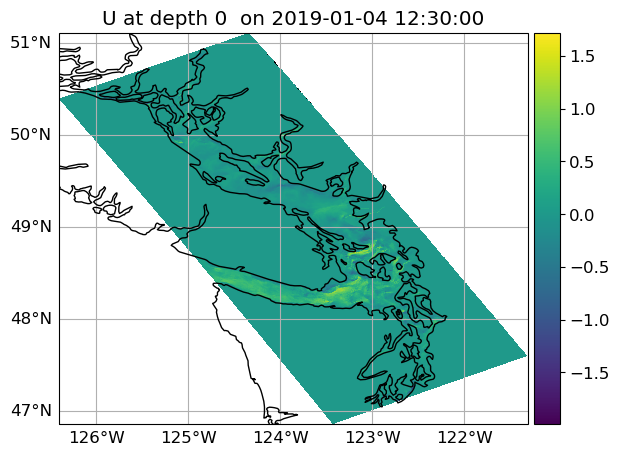

In [51]:
fieldset.U.show()

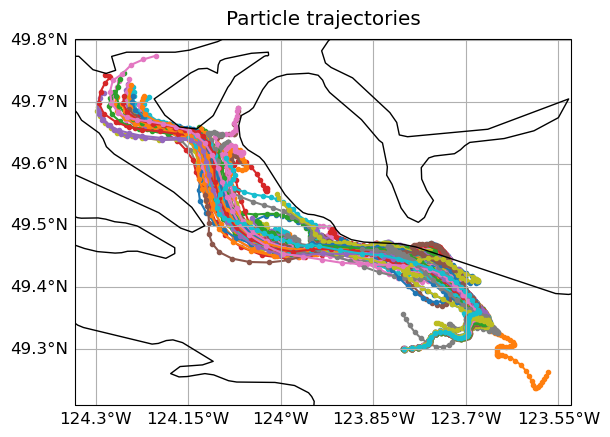

<module 'matplotlib.pyplot' from '/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [65]:
plotTrajectoriesFile(prefix + '_NEMO_3D.zarr')

In [70]:
plotTrajectoriesFile(prefix + '_NEMO_3D.zarr', mode='movie2d_notebook')


In [ ]:
plotTrajectoriesFile(prefix + '_NEMO_3D.zarr', mode='movie2d_notebook', recordedvar=data.z)

Tests with different particle initializations

In [130]:
# Paths and filenames
paths = {
    'coords': '/data/SalishSeaCast/grid/coordinates_seagrid_SalishSea201702.nc',
    'mask': '/data/SalishSeaCast/grid/mesh_mask201702.nc',
    'results': '/ocean/mattmiller/MOAD/analysis-matt/results/parcels/test',
}

# Load coords and mask files and extract grid variables
coords, mask = [xr.open_dataset(paths[key], decode_times=False) for key in ('coords', 'mask')]
gridlon, gridlat = [coords[key][0, ...].values for key in ('glamt', 'gphit')]
tmask = mask.tmask[0, 0, ...].values

# Define release parameters
location = 'Haro Strait' # there are predefined location names built into SalishSeaTools, under salishsea_tools.places.PLACES which can be found easily on github
# How would I set a custom lat lon for start location?
n = 100   # number of particles
r = 5   # radius of particle cloud [m]

# Start time, duration and timestep
start = datetime(2019, 1, 1, 12, 30, 0) # year, month, day, hour, minute, second
duration = timedelta(days=3) # the total duration of the simulation
dt = timedelta(seconds=90) # the timestep - toggle between + and - to run forwards or reverse
# is this the timestep that parcels uses or of the fieldset from SalishSeaCast?

# Create Gaussian distribution around release point
mean, cov = [0, 0], [[r**2, 0], [0, r**2]]
x_offset, y_offset = np.random.multivariate_normal(mean, cov, n).T
lon, lat = (-123.25, 48.5)
lons = lon + x_offset / 111000 / np.cos(np.deg2rad(lat)) # this code might be used to convert from SalishSeaCast's grid to a lat lon grid, since it is an angled domain grid
lats = lat + y_offset / 111000

# Forcing daterange (I add 1-day buffers)
daterange = [start - timedelta(days=1), start + duration + timedelta(days=1)]

# Output file prefix
strings = [location] + [t.strftime('%Y%m%dT%H%M%S') for t in (start, start + duration)]
prefix = os.path.join(paths['results'], '_'.join(strings))

In [131]:
# Load SalishSeaCast results into fieldset
fieldset = fieldset_from_nemo(daterange, paths['coords'])

In [143]:
# Execute NEMO-only, 3D run, release randomly dispersed over 100 m depth
pset = ParticleSet.from_list(fieldset, JITParticle, lon=lons, lat=lats, depth=np.random.random_sample(n)*(100), time=np.repeat(start, n))
kernel = AdvectionRK4_3D
output_file = pset.ParticleFile(name=prefix + '_NEMO_3D.zarr', outputdt=timedelta(hours=1))
pset.execute(
    kernel, runtime=duration, dt=dt, output_file=output_file,
    recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},
)

INFO: Compiled ArrayJITParticleAdvectionRK4_3D ==> /tmp/parcels-2928/lib389fa93352b83cfee587f5d0dee0212d_0.so
INFO: Output files are stored in /ocean/mattmiller/MOAD/analysis-matt/results/parcels/test/Haro Strait_20190101T123000_20190104T123000_NEMO_3D.zarr.
100%|██████████| 259200.0/259200.0 [01:24<00:00, 3053.44it/s]


In [146]:
%%capture

# Make initial figure
fig, axs = plt.subplots(1, 2, figsize=(17, 8), gridspec_kw={'wspace': 0.1})
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # do I need this in this side by side?
l0 = axs[0].scatter([data.lon], [data.lat], s=50, c=[data.z], vmin=0, vmax=100, edgecolor='k')
l1 = axs[1].scatter([data.lon], [data.z], s=50, c=[data.z], vmin=0, vmax=100, edgecolor='k')
t0 = axs[0].text(0.02, 0.02, '', transform=axs[0].transAxes)
t1 = axs[1].text(0.02, 0.02, '', transform=axs[1].transAxes)
data = xr.open_dataset(prefix + '_NEMO_3D.zarr') # This line opens the dataset of the particles, so you don't have to run the 
# particle simulation every time you come back to this notebook to play around with it, as long as you want to keep the particles the same
axs[0].contourf(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='gray')
axs[0].contour(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='k')
axs[0].set_xlim([-125, -122])
axs[1].set_xlim([-125, -122])
axs[0].set_ylim([47.5, 49.5])
axs[1].set_ylim([200, 0])
axs[1].set_ylabel('Depth [m]')
axs[0].set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l1, cax=cax, label='Depth [m]')

# Init function
def init():
    t0.set_text('')
    t1.set_text('')
    l0.set_offsets(np.empty((0, 2)))
    l1.set_offsets(np.empty((0, 2)))
    l0.set_array(np.empty(0))
    l1.set_array(np.empty(0))
    return l0, l1, t0, t1,

# Animate function
def animate(hour):
    tstamp = data.time[0, hour].values.astype('datetime64[s]').astype(datetime)
    t0.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    t1.set_text(tstamp.strftime('%Y-%b-%d %H:%M UTC'))
    l0.set_offsets(np.vstack([data.lon[:, hour], data.lat[:, hour]]).T)
    l1.set_offsets(np.vstack([data.lon[:, hour], data.z[:, hour]]).T)
    l0.set_array(data.z[:, hour])
    l1.set_array(data.z[:, hour])
    return l0, l1, t0, t1,

# Build animation
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=73, interval=100, blit=True)

In [147]:
# Render animation
HTML(anim.to_html5_video())

Some of the particles were "stuck" right from initialization, which tells me they were initialized greater than the bottom depth at that location

/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/mattmiller/conda_envs/analysis-matt/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


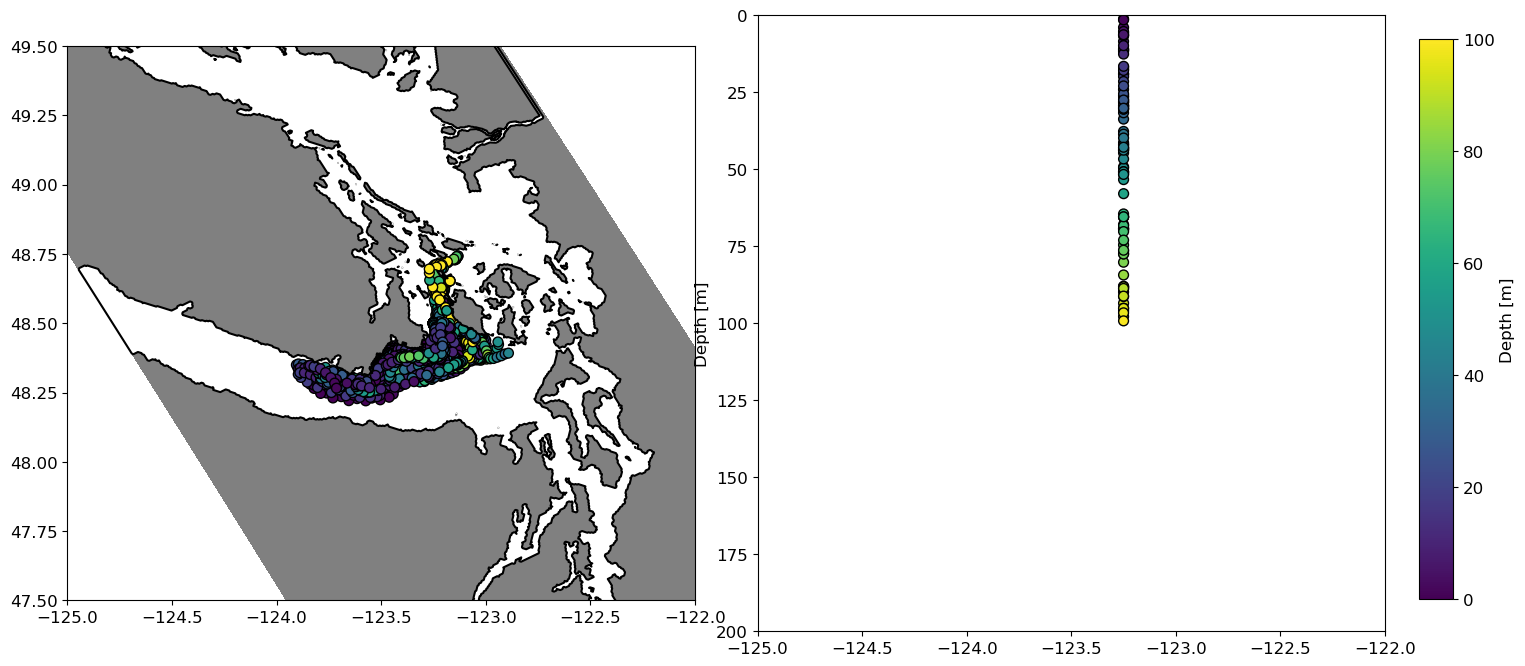

In [145]:
# Make initial figure
fig, axs = plt.subplots(1, 2, figsize=(17, 8), gridspec_kw={'wspace': 0.1})
cax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # do I need this in this side by side?
l0 = axs[0].scatter([data.lon], [data.lat], s=50, c=[data.z], vmin=0, vmax=100, edgecolor='k')
l1 = axs[1].scatter([data.lon[:,0]], [data.z[:,0]], s=50, c=[data.z[:,0]], vmin=0, vmax=100, edgecolor='k')
t0 = axs[0].text(0.02, 0.02, '', transform=axs[0].transAxes)
t1 = axs[1].text(0.02, 0.02, '', transform=axs[1].transAxes)
data = xr.open_dataset(prefix + '_NEMO_3D.zarr') # This line opens the dataset of the particles, so you don't have to run the 
# particle simulation every time you come back to this notebook to play around with it, as long as you want to keep the particles the same
axs[0].contourf(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='gray')
axs[0].contour(gridlon, gridlat, tmask, levels=[-0.01, 0.01], colors='k')
axs[0].set_xlim([-125, -122])
axs[1].set_xlim([-125, -122])
axs[0].set_ylim([47.5, 49.5])
axs[1].set_ylim([200, 0])
axs[1].set_ylabel('Depth [m]')
axs[0].set_aspect(1/np.sin(np.deg2rad(49)))
fig.colorbar(l1, cax=cax, label='Depth [m]')